In [1]:
# 自动重新加载外部module，使得修改代码之后无需重新import
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from hdd.device.utils import get_device

import torch
import torch.nn as nn
import torchvision

# 设置训练数据的路径
DATA_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置TensorBoard的路径
TENSORBOARD_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置预训练模型参数路径
TORCH_HUB_PATH = "~/workspace/hands-dirty-on-dl/pretrained_models"
torch.hub.set_dir(TORCH_HUB_PATH)
# 挑选最合适的训练设备
DEVICE = get_device(["cuda", "cpu"])
max_epochs = 150
print("Use device: ", DEVICE)

Use device:  cuda


# Show mask and bbox

In [2]:
from hdd.scripts.detection.coco_utils import get_coco
from pathlib import Path

COCO_ROOT = Path(DATA_ROOT).expanduser() / "coco"
is_train = False
image_set = "train" if is_train else "val"
num_classes, mode = {"coco": (91, "instances"), "coco_kp": (2, "person_keypoints")}[
    "coco"
]
with_masks = True

ds = get_coco(
    root=COCO_ROOT,
    image_set=image_set,
    transforms=None,
    mode=mode,
    use_v2=False,
    with_masks=with_masks,
)
print("!" * 100)
print("Basic info about dataset")
ds.coco.info()
print("!" * 100)
print("Number of images:", len(ds))
print("Total categories:", len(ds.coco.cats))
for i, cat_id in enumerate(ds.coco.getCatIds()):
    category = ds.coco.cats[cat_id]
    if i % 2 == 0:
        print(category, end="")
    else:
        print(", ", category)

loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Basic info about dataset
description: COCO 2017 Dataset
url: http://cocodataset.org
version: 1.0
year: 2017
contributor: COCO Consortium
date_created: 2017/09/01
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Number of images: 5000
Total categories: 80
{'supercategory': 'person', 'id': 1, 'name': 'person'},  {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}
{'supercategory': 'vehicle', 'id': 3, 'name': 'car'},  {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}
{'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},  {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}
{'supercategory': 'vehicle', 'id': 7, 'name': 'train'},  {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}
{'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, 

# Plot Bounding Box

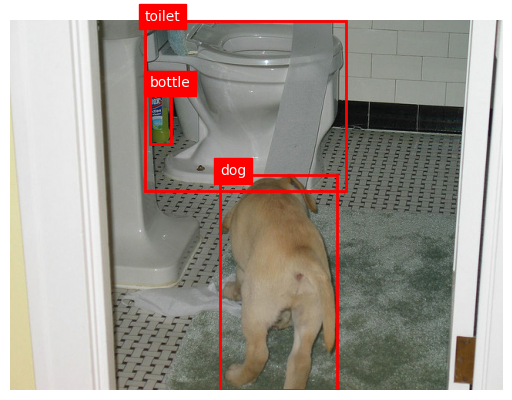

In [3]:
# Basic plot function
from matplotlib import pyplot as plt


def get_category_name(ds, category_ids) -> list[str]:
    """Get category names from category IDs."""
    if isinstance(category_ids, torch.Tensor):
        category_ids = category_ids.cpu().tolist()
    return [ds.coco.cats[cat_id]["name"] for cat_id in category_ids]


# get category from dataset
data_idx = 543
img, target = ds[data_idx]
category_names = get_category_name(ds, target["labels"])
# plot image
plt.imshow(img)
ax = plt.gca()
# plot boxes
for box, category_name in zip(target["boxes"], category_names):
    xmin, ymin, xmax, ymax = box
    ax.add_patch(
        plt.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            fill=False,
            color="red",
            linewidth=2,
        )
    )
    ax.text(
        xmin, ymin, category_name, fontsize=10, color="white", backgroundcolor="red"
    )
plt.axis("off")
plt.show()

# Plot Polygon

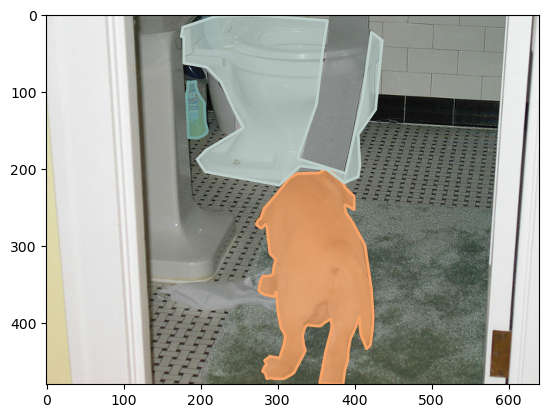

In [4]:
import numpy as np
import pycocotools.mask as maskUtils
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

data_idx = 543
img, target = ds[data_idx]
plt.imshow(img)

annotation_list = ds.coco.imgToAnns[target["image_id"]]
ax = plt.gca()
ax.set_autoscale_on(False)
polygons = []
color = []
for ann in annotation_list:
    c = (np.random.random((1, 3)) * 0.6 + 0.4).tolist()[0]
    if "segmentation" in ann:
        if type(ann["segmentation"]) == list:
            # polygon
            for seg in ann["segmentation"]:
                poly = np.array(seg).reshape((int(len(seg) / 2), 2))
                polygons.append(Polygon(poly))
                color.append(c)
p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.7)
ax.add_collection(p)
p = PatchCollection(polygons, facecolor="none", edgecolors=color, linewidths=2)
ax.add_collection(p)

# Plot KeyPoints

In [5]:
from pycocotools.coco import COCO
from hdd.scripts.detection.coco_utils import _coco_remove_images_without_annotations

is_train = False
image_set = "train" if is_train else "val"
num_classes, mode = {"coco": (91, "instances"), "coco_kp": (2, "person_keypoints")}[
    "coco_kp"
]
with_masks = True

ds = get_coco(
    root=COCO_ROOT,
    image_set=image_set,
    transforms=None,
    mode=mode,
    use_v2=False,
    with_masks=with_masks,
)
ds = _coco_remove_images_without_annotations(ds)
coco_api = ds.dataset.coco
print("!" * 100)
print("Number of images:", len(ds))
print("Total categories:", len(coco_api.cats))
for i, cat_id in enumerate(coco_api.getCatIds()):
    category = coco_api.cats[cat_id]
    if i % 2 == 0:
        print(category, end="")
    else:
        print(", ", category)

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Number of images: 2012
Total categories: 1
{'supercategory': 'person', 'id': 1, 'name': 'person', 'keypoints': ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle'], 'skeleton': [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 12], [7, 13], [6, 7], [6, 8], [7, 9], [8, 10], [9, 11], [2, 3], [1, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7]]}

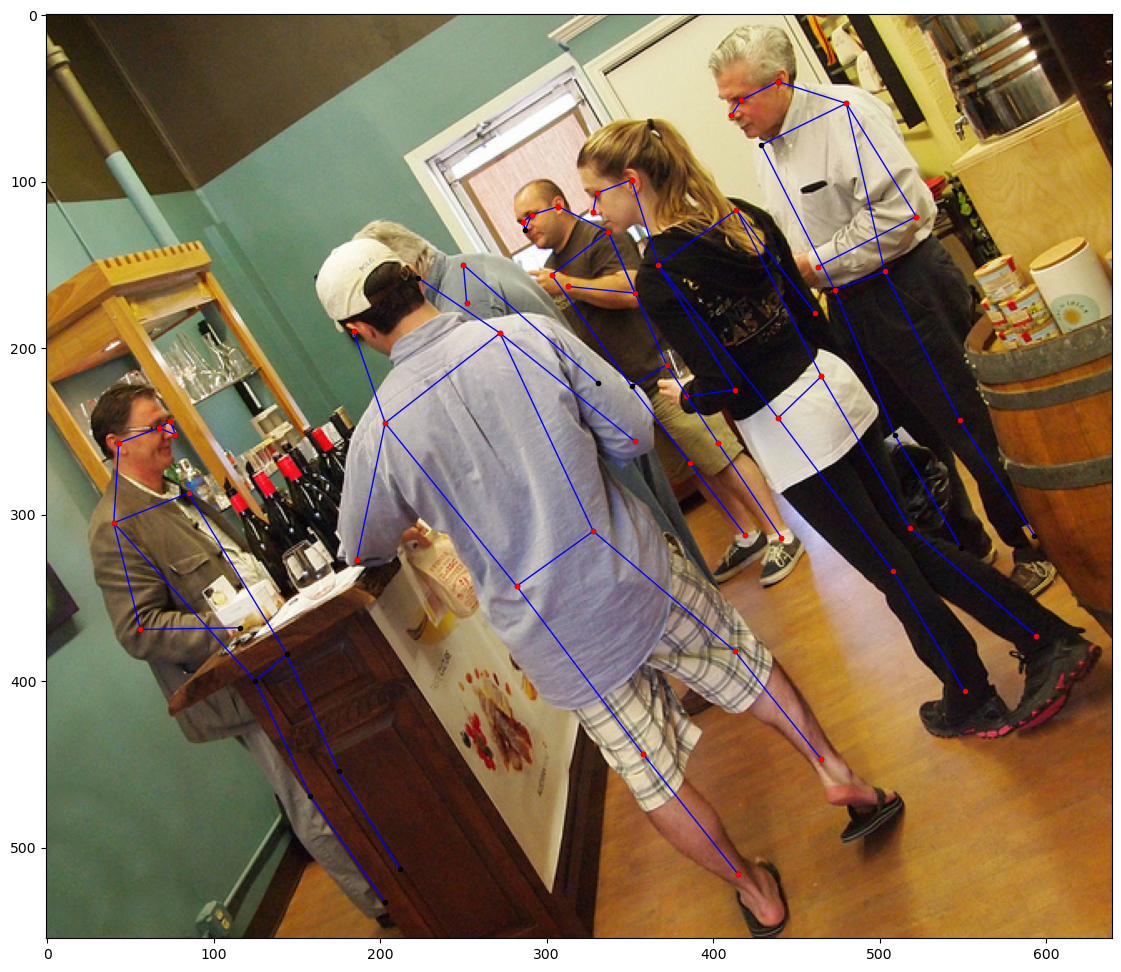

In [6]:
data_idx = 14
img, target = ds[data_idx]
plt.figure(figsize=(14, 12))
plt.imshow(img)
sks = np.array(coco_api.loadCats(1)[0]["skeleton"]) - 1
total_objects = target["keypoints"].shape[0]
for i in range(total_objects):
    kp = target["keypoints"][i].numpy()
    # turn skeleton into zero-based index
    x = kp[:, 0]
    y = kp[:, 1]
    v = kp[:, 2]
    # if visibility == 0 that keypoint not in the image.
    # if visibility == 1 that keypoint is in the image BUT not visible namely maybe behind of an object.
    # if visibility == 2 that keypoint looks clearly. not hidden.

    for sk in sks:
        if np.all(v[sk] > 0):
            plt.plot(x[sk], y[sk], linewidth=1, color="blue")
    plt.plot(
        x[v > 0],
        y[v > 0],
        "o",
        markersize=2,
        markerfacecolor="k",
        markeredgecolor="k",
        markeredgewidth=2,
    )
    plt.plot(
        x[v > 1],
        y[v > 1],
        "o",
        markersize=2,
        markerfacecolor="red",
        markeredgecolor="red",
        markeredgewidth=2,
    )

# Plot Caption

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Text(0.5, 1.0, 'A black Honda motorcycle parked in front of a garage.')

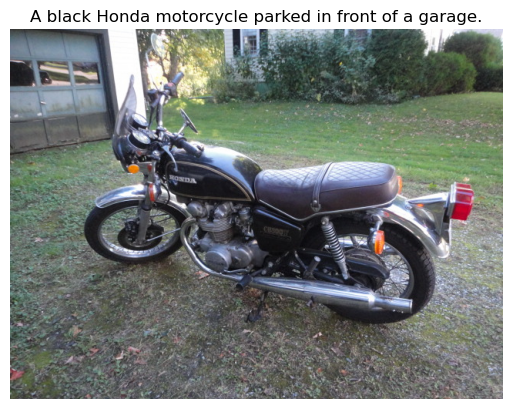

In [7]:
from pycocotools.coco import COCO

annotation_file = COCO_ROOT / "annotations" / "captions_val2017.json"
coco_api = COCO(annotation_file)

anno_id = 38
annotation = coco_api.anns[38]
image_id = annotation["image_id"]
image = coco_api.loadImgs(image_id)[0]
img_path = COCO_ROOT / "val2017" / image["file_name"]
img = plt.imread(img_path)
plt.imshow(img)
plt.axis("off")
plt.title(annotation["caption"])